# Connect to Google Drive

# Install Libraries

# Configure Kaggle

# Download Dataset

In [ ]:
!kaggle datasets download -d achmadnoer/alfabet-bisindo -p /content/drive/MyDrive/DataScience/Datasets

Dataset URL: https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo
License(s): CC0-1.0
 90% 103M/115M [00:01<00:00, 115MB/s] 
100% 115M/115M [00:01<00:00, 99.0MB/s]


In [ ]:
!unzip /content/drive/MyDrive/DataScience/Datasets/alfabet-bisindo.zip -d /content/drive/MyDrive/DataScience/Datasets

Archive:  /content/drive/MyDrive/DataScience/Datasets/alfabet-bisindo.zip
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body dot (1).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body dot (2).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body dot (3).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body dot (4).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body white (1).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body white (2).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body white (3).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/body white (4).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/wall white (1).jpg  
  inflating: /content/drive/MyDrive/DataScience/Datasets/Citra BISINDO/A/wall white (2).

In [ ]:
!mv '/content/drive/MyDrive/DataScience/Datasets/Citra BISINDO' /content/drive/MyDrive/DataScience/Datasets/bisindo

# Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import joblib
import imgaug.augmenters as iaa
import sklearn

In [ ]:
print(f'Mediapipe Version: {mp.__version__}')
print(f'OpenCV Version: {cv2.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Numpy Version: {np.__version__}')
print(f'Scikit Learn Version: {sklearn.__version__}')
print(f'Joblib Version: {joblib.__version__}')

Mediapipe Version: 0.10.15
OpenCV Version: 4.10.0
Pandas Version: 2.2.2
Numpy Version: 1.26.4
Scikit Learn Version: 1.5.2
Joblib Version: 1.4.2


# Define Constants

In [ ]:
IMG_HEIGHT    = 256
IMG_WIDTH     = 256
INPUT_DIR     = '/content/drive/MyDrive/DataScience/Datasets/bisindo'
AUGMENTED_DIR = '/content/drive/MyDrive/DataScience/Datasets/bisindo-augmented'

NUM_AUGMENTED_IMAGE = 50
CSV_FILENAME        = '/content/drive/MyDrive/DataScience/Datasets/bisindo-features.csv'
TRAIN_CSV           = '/content/drive/MyDrive/DataScience/Datasets/bisindo-train.csv'
VAL_CSV             = '/content/drive/MyDrive/DataScience/Datasets/bisindo-val.csv'
TEST_CSV            = '/content/drive/MyDrive/DataScience/Datasets/bisindo-test.csv'

# Image Augmentation

In [ ]:
seq = iaa.Sequential([
    iaa.Resize((IMG_HEIGHT, IMG_WIDTH)),
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-25, 25)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0, 1.0))
])

def augment_images(input_dir, output_dir, num_augmented_image):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for letter in os.listdir(input_dir):
        letter_path = os.path.join(input_dir, letter)
        output_letter_path = os.path.join(output_dir, letter)
        os.makedirs(output_letter_path, exist_ok=True)

        for img_file in os.listdir(letter_path):
            img_path = os.path.join(letter_path, img_file)
            img = cv2.imread(img_path)

            for i in range(num_augmented_image):  # Augment each image X times
                augmented_image = seq(image=img)
                cv2.imwrite(os.path.join(output_letter_path, f"{img_file[:-4]}_aug_{i}.jpg"), augmented_image)

augment_images(INPUT_DIR, AUGMENTED_DIR, NUM_AUGMENTED_IMAGE)


# Extract Hand Landmark Features

In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_landmarks(image):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            landmarks = []
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
            return landmarks
    return None

def process_images(input_dir, csv_filename):
    data = []
    for letter in sorted(os.listdir(input_dir)):
        letter_path = os.path.join(input_dir, letter)
        label = letter
        print(f'Processing {label}')
        for img_file in sorted(os.listdir(letter_path)):
            img_path = os.path.join(letter_path, img_file)
            img = cv2.imread(img_path)
            landmarks = extract_landmarks(img)
            if landmarks:  # Only save if landmarks were detected
                row = [label] + [coord for lm in landmarks for coord in lm]
                data.append(row)

    columns = ['label'] + [f'hand_{i}_x' for i in range(42)] + [f'hand_{i}_y' for i in range(42)] + [f'hand_{i}_z' for i in range(42)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(csv_filename, index=False)

    print('Image Features Extracted')

process_images(AUGMENTED_DIR, CSV_FILENAME)


Processing A


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processing B
Processing C
Processing D
Processing E
Processing F
Processing G
Processing H
Processing I
Processing J
Processing K
Processing L
Processing M
Processing N
Processing O
Processing P
Processing Q
Processing R
Processing S
Processing T
Processing U
Processing V
Processing W
Processing X
Processing Y
Processing Z
Image Features Extracted


# Preprocessing Data, Get rid of NaN values

In [ ]:
# Load datasets
df = pd.read_csv(CSV_FILENAME)
df.fillna(0, inplace=True)
df.head()

,label,hand_0_x,hand_1_x,hand_2_x,hand_3_x,hand_4_x,hand_5_x,hand_6_x,hand_7_x,hand_8_x,...,hand_32_z,hand_33_z,hand_34_z,hand_35_z,hand_36_z,hand_37_z,hand_38_z,hand_39_z,hand_40_z,hand_41_z
0,A,-0.001884,0.693972,3.161227e-07,0.124288,0.711344,-0.034855,0.229433,0.689180,-0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,0.014768,0.787036,7.649916e-08,0.152054,0.769668,-0.030148,0.263977,0.728033,-0.085495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,0.889007,0.869320,-7.139865e-07,0.770297,0.825052,-0.032365,0.678934,0.760918,-0.083063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,0.086617,0.597326,-1.070649e-06,0.178102,0.564008,-0.066909,0.260309,0.490916,-0.113287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,0.870403,0.871914,-6.897396e-07,0.759888,0.825209,-0.033860,0.671983,0.762084,-0.086520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split Dataset

In [ ]:
def split_data(csv_filename, train_csv_dir, val_csv_dir, test_csv_dir):
    df = pd.read_csv(csv_filename)
    train, temp = train_test_split(df, test_size=0.3, stratify=df['label'])
    val, test = train_test_split(temp, test_size=0.5, stratify=temp['label'])

    train.to_csv(train_csv_dir, index=False)
    val.to_csv(val_csv_dir, index=False)
    test.to_csv(test_csv_dir, index=False)

split_data(CSV_FILENAME, TRAIN_CSV, VAL_CSV, TEST_CSV)


# Model Training

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

train = train_df.fillna(0)
val = val_df.fillna(0)
test = test_df.fillna(0)

train.head()

,label,hand_0_x,hand_1_x,hand_2_x,hand_3_x,hand_4_x,hand_5_x,hand_6_x,hand_7_x,hand_8_x,...,hand_32_z,hand_33_z,hand_34_z,hand_35_z,hand_36_z,hand_37_z,hand_38_z,hand_39_z,hand_40_z,hand_41_z
0,V,0.670988,0.843263,1.866216e-06,0.579206,0.814252,-0.084701,0.478233,0.764089,-0.150252,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Z,0.335375,0.384050,9.331748e-07,0.406284,0.328421,-0.072036,0.492944,0.274682,-0.076021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,A,0.772967,0.717366,-2.343888e-07,0.694444,0.720712,-0.039332,0.608590,0.693907,-0.074278,...,-0.038932,0.161547,0.515244,-0.068100,0.151943,0.566202,-0.050862,0.152728,0.574197,-0.030475
3,F,0.927311,0.318015,1.632224e-06,0.806915,0.202754,-0.034858,0.667703,0.197839,-0.065258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,D,0.314253,0.678808,1.747256e-07,0.381792,0.668594,-0.008039,0.458386,0.641980,-0.026352,...,-0.070557,0.784168,0.714754,-0.100308,0.762662,0.759483,-0.087652,0.748372,0.766690,-0.071746


In [ ]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_val = val.drop(columns=['label'])
y_val = val['label']
X_test = test.drop(columns=['label'])
y_test = test['label']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            Classifier  Validation Accuracy  Validation F1 Score  \
0        Random Forest             0.991705             0.991694   
1                  SVM             0.876037             0.870217   
2  Logistic Regression             0.854378             0.851298   
3  K-Nearest Neighbors             0.981106             0.980962   
4        Decision Tree             0.959447             0.959465   
5    Gradient Boosting             0.988940             0.988916   
6          Naive Bayes             0.417972             0.312641   

   Test Accuracy  Test F1 Score  
0       0.993551       0.993561  
1       0.865500       0.859199  
2       0.842469       0.838458  
3       0.978812       0.978782  
4       0.959466       0.959518  
5       0.988485       0.988498  
6       0.417780       0.311018  


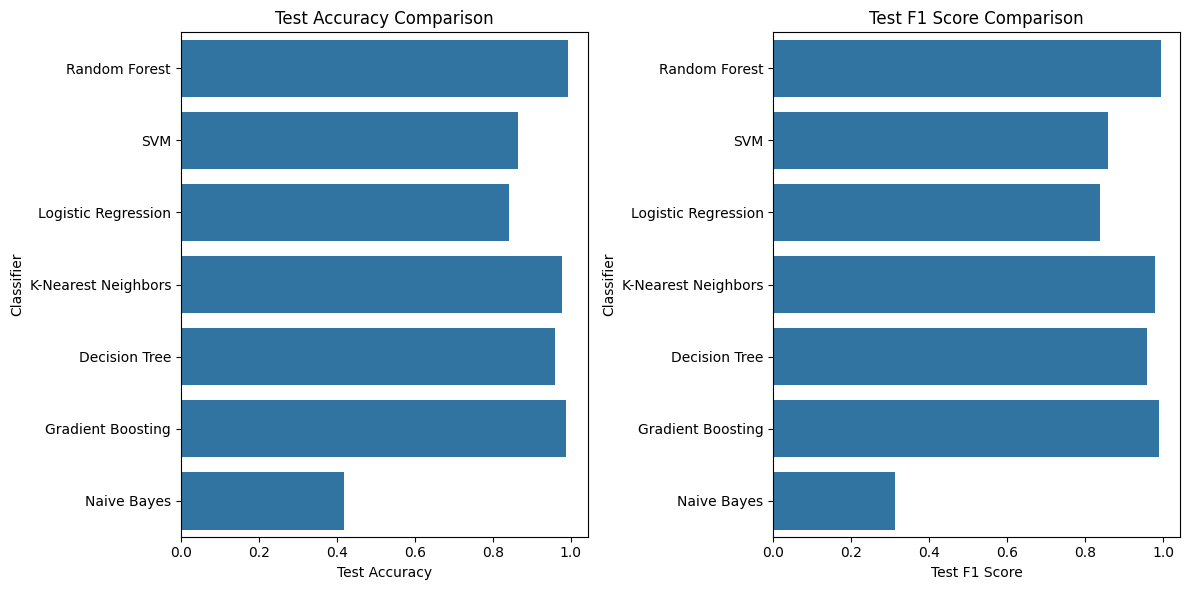

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB()
}

results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    results.append({
        'Classifier': name,
        'Validation Accuracy': val_accuracy,
        'Validation F1 Score': val_f1,
        'Test Accuracy': test_accuracy,
        'Test F1 Score': test_f1
    })

results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Test Accuracy', y='Classifier', data=results_df)
plt.title('Test Accuracy Comparison')

plt.subplot(1, 2, 2)
sns.barplot(x='Test F1 Score', y='Classifier', data=results_df)
plt.title('Test F1 Score Comparison')

plt.tight_layout()
plt.show()


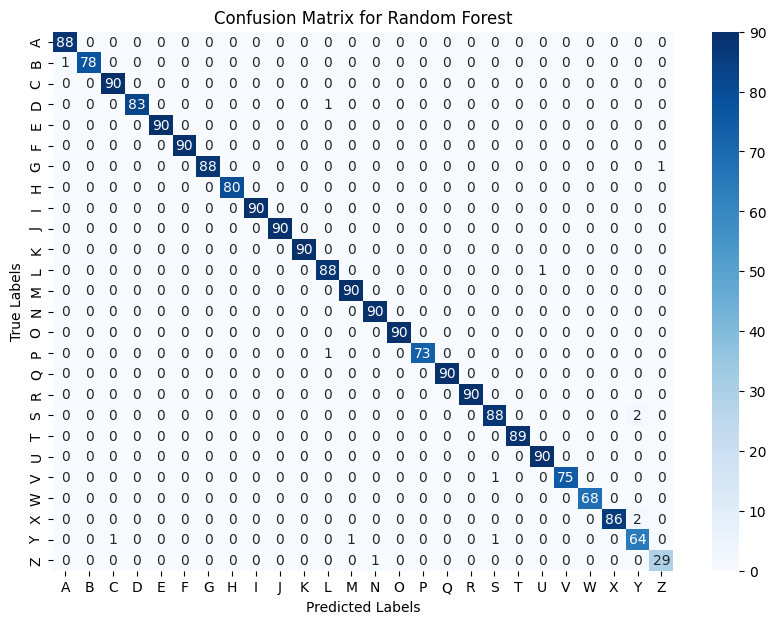

In [ ]:
random_forest_clf = classifiers['Random Forest']

y_test_pred_rf = random_forest_clf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest_clf.classes_, yticklabels=random_forest_clf.classes_)

plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import joblib

clf = classifiers['Random Forest']

model_filename = '/content/drive/MyDrive/DataScience/Datasets/rf_bisindo_classifier_99.pkl'
joblib.dump(clf, model_filename)

print(f"Random Forest model saved to {model_filename}")

Random Forest model saved to /content/drive/MyDrive/DataScience/Datasets/rf_bisindo_classifier_99.pkl
